<h1>Geopandas Data Analysis of Amenities Distribution & City Demographics</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import folium
import branca.colormap as cm

C:\Users\Ken\anaconda3\envs\geo-env\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


<h2>Loading Data</h2>

In [2]:
# Latest OSM amenities generated using provided scripts
amenities = pd.read_json('data/amenities-vancouver-v2.json', lines=True)
amenities = amenities.drop('timestamp', axis=1)

In [3]:
# iMapBC data
municipality = gpd.read_file('data/municipality/ABMS_MUNI_polygon.shp')
demographics = gpd.read_file('data/demographics/SDVPPNHS_polygon.shp')
languages = gpd.read_file('data/languages/CENPROFCSD_polygon.shp')

In [4]:
# Convert the crs of data files
municipality = municipality.to_crs('epsg:4326')
demographics = demographics.to_crs('epsg:4326')
languages = languages.to_crs('epsg:4326')

<h2>Amenities Data</h2>

In [5]:
# Convert amenities to GeoDataFrame
crs={'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(amenities['lon'], amenities['lat'])]
amenities = gpd.GeoDataFrame(amenities, crs=crs, geometry=geometry)

C:\Users\Ken\anaconda3\envs\geo-env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
# Hardcode the relevant food and drink service amenities
RESTAURANT_AMENITY = [
    'cafe', 'fast_food', 'bbq',
    'restaurant', 'pub', 'bar', 
    'food_court', 'ice_cream', 'nightclub',
    'marketplace', 'bistro', 'juice_bar',
    'lounge', 'biergarten', 'casino']

In [7]:
# Filtering for food and drink service type amenities
food_amenities = amenities[amenities['amenity'].isin(RESTAURANT_AMENITY)]
# Remove amenities with no name
food_amenities = food_amenities[food_amenities['name'].notna()]
# Extract cuisine from tags and create new column
food_amenities['cuisine'] = food_amenities['tags'].apply(lambda t: t.get('cuisine'))
food_amenities = food_amenities.dropna()

In [8]:
# View top 25 rows
pd.set_option('display.min_rows', 25)

In [9]:
# Count occurrences of tags
tags = food_amenities['tags'].apply(list).apply(pd.Series).stack().reset_index(drop=True)
print(tags.value_counts())

cuisine                 4692
addr:street             2703
addr:housenumber        2674
brand                   1811
brand:wikidata          1782
brand:wikipedia         1755
takeaway                1743
addr:city               1719
opening_hours           1290
phone                   1231
website                 1173
addr:postcode            915
                        ... 
city                       1
cuisine:japanese           1
loc_name                   1
phone:mnemonic             1
internet_access:type       1
leisure                    1
cocktails                  1
haunted                    1
changing_table:fee         1
source:name:url            1
disused:craft              1
unit                       1
Length: 155, dtype: int64


In [10]:
# Count occurrence of cuisines
food_amenities['cuisine'].value_counts()

coffee_shop                                     624
pizza                                           572
sandwich                                        378
burger                                          367
chinese                                         253
sushi                                           249
japanese                                        189
indian                                          145
vietnamese                                      139
mexican                                         130
chicken                                         116
bubble_tea                                       92
                                               ... 
coffee_shop;baked_goods                           1
pizza;burger;coffee_shop                          1
pancake;breakfast                                 1
grilled_cuisine;chicken;meat;vegetables;rice      1
italian, pizza, pasta                             1
chicken;tacos                                     1
pizza;artisa

In [11]:
# Filter for amenities unrelated to food and drink service
non_food_amenities = amenities[amenities['amenity'].isin(RESTAURANT_AMENITY) == False]
non_food_amenities = non_food_amenities[non_food_amenities['name'].notna()]

In [12]:
# Count non food related amenities within municipality
municipality['non_food_amenity_count'] = \
    municipality.apply(
        lambda x: len(non_food_amenities[non_food_amenities.within(x['geometry'])]), axis=1)

# Count food related amenities within municipality
municipality['food_amenity_count'] = \
    municipality.apply(
        lambda x: len(food_amenities[food_amenities.within(x['geometry'])]), axis=1)

# Compute percentage of food amenities
municipality['food_amenity_density'] = \
        municipality['food_amenity_count'] / \
        (municipality['food_amenity_count'] + municipality['non_food_amenity_count'])

<h2>Demographics Data</h2>

In [13]:
# Extracting relevant demographic columns
demographics_flt = demographics[['CNSS_SBDVM', 'CNSS_SBDVC', 'CEN_DV_NM', 'QLY_QL_POP', 
                                 'POP_TOTAL', 'POP_4UNDER', 'POP_5_9',  'POP_10_14',  'POP_15_19',  
                                 'POP_20_24',  'POP_25_29',  'POP_30_34',  'POP_35_39',  'POP_40_44',  
                                 'POP_45_49',  'POP_50_54',  'POP_55_59',  'POP_60_64',  'POP_65_69',
                                 'POP_70_74',  'POP_75_79',  'POP_80_84',  'POP_85PLUS',  'PP_MDN_GE',
                                 'HSHLD_N', 'QLTY_QLFDD', 'HI_MEDIAN', 'HI_5KUNDER', 'HI_5_10', 'HI_10_15',
                                 'HI_15_20', 'HI_20_30', 'HI_30_40', 'HI_40_50', 'HI_50_60', 
                                 'HSHLDNCM_6', 'HSHLDNCM_8', 'HI_125_125', 'HI_125_150', 'HI_150K_PL', 
                                 'WFED_U12', 'WFED_12', 'WFED_AD', 'WFED_CGT16', 'WFED_C_16', 
                                 'LBF_TOTAL', 'LBF_MALE', 'LBF_FEMALE']]

demographics_flt = demographics_flt[(demographics_flt['CNSS_SBDVC'] == 'City') |
                                    (demographics_flt['CNSS_SBDVC'] == 'District Municipality')]

In [14]:
# Rename certain municipalities for joining municipality and demographics
demographics_flt.at[2, 'CNSS_SBDVM'] = 'Langley - City'
demographics_flt.at[37, 'CNSS_SBDVM'] = 'Langley - District'
demographics_flt.at[67, 'CNSS_SBDVM'] = 'North Vancouver - District'
demographics_flt.at[68, 'CNSS_SBDVM'] = 'North Vancouver - City'

In [15]:
# Join municipality and demographics
muni_demo_join = municipality.merge(demographics_flt, left_on='ABRVN', right_on='CNSS_SBDVM')

In [16]:
# Plot distribution of city household income
def plot_household_income():
    household_income = city_demographics[['HI_5KUNDER', 'HI_5_10', 'HI_10_15', 
                                      'HI_15_20', 'HI_20_30', 'HI_30_40', 
                                       'HI_40_50', 'HI_50_60', 'HSHLDNCM_6', 
                                       'HSHLDNCM_8', 'HI_125_125', 'HI_125_150', 
                                       'HI_150K_PL']]
    
    household_income.T.plot.bar(subplots=True, title=['Household Income Distribution in ' + CITY_NAME + ''])
    plt.legend(['# of households within income range'])
    plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), 
               ('[,4K]', '[5K, 10K]', '[10K, 15K]', '[15K, 20K]', '[20K, 30K]', 
                '[30K, 40K]', '[40K, 50K]', '[50K, 60K]', '[60K, 80K]', '[80K, 100K]',
                '[100K, 125K]', '[125K, 150K]', '[150K,]'))
    plt.show()

In [17]:
# Plot distribution of city population by age
def plot_populations_by_age():
    populations = city_demographics[['POP_4UNDER', 'POP_5_9', 'POP_10_14',
                                     'POP_15_19', 'POP_20_24', 'POP_25_29', 
                                     'POP_30_34', 'POP_35_39', 'POP_40_44', 
                                     'POP_45_49', 'POP_50_54', 'POP_60_64', 
                                     'POP_65_69', 'POP_70_74', 'POP_75_79', 
                                     'POP_80_84', 'POP_85PLUS']]

    populations.T.plot.bar(subplots=True, title=['Population Distribution in ' + CITY_NAME + ' by Age'])
    plt.legend(['# of people within age range'])
    plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16), 
               ('[,4]', '[5, 9]', '[10, 14]', '[15, 19]', '[20, 24]', 
                '[25, 29]', '[30, 34]', '[35, 39]', '[40, 44]', '[45, 49]', 
                '[50, 54]', '[60, 64]', '[65, 69]', '[70, 74]', '[75, 79]', 
                '[80, 84]', '[85,]'))
    plt.show()

In [18]:
# convert language to column name in data
# non-exhaustive list; add languages as needed
def LANG_KEY(lang):
    if lang == 'English':
        return 'ENG'
    elif lang == 'French':
        return 'FR'
    elif lang == 'Chinese':
        return 'CHINESE_N_O_S'
    elif lang == 'Punjabi':
        return 'PNJB_PNJBI'
    elif lang == 'Tagalog':
        return 'TAG_PI_FI'
    elif lang == 'Vietnamese':
        return 'VIETNMSE'
    else:
        return lang.upper()

# non-exhaustive list; add languages as needed
# exclude English, the dominant majority 
languages_selected = [
    LANG_KEY('French'),
    LANG_KEY('Mandarin'),
    LANG_KEY('Cantonese'),
    LANG_KEY('Korean'),
    LANG_KEY('Japanese'),
    LANG_KEY('Tagalog'),
    LANG_KEY('Punjabi'),
    LANG_KEY('Hindi')
]
    
# filter out certain columns and values
languages_flt = languages[['CNSS_SBDVM'] + languages_selected]

In [19]:
# Plot distribution of languages spoken at home
# Excludes English because in almost every city, it is the majority language by such a 
# large margin, it makes the plot unreadable
def plot_languages_spoken():
    city_languages.drop('CNSS_SBDVM', axis=1) \
        .T.plot.bar(subplots=True, title=['Languages Spoken at Home in ' + CITY_NAME])
    plt.legend(['Languages'])
    plt.show()

<h2>Mapping Data</h2>

In [20]:
# Given a municipality, calculate a 'score' based on
# population, income median, and cuisine density
def calculate_score(r, hi_mean, pop_mean):
    score = 0
    score = score + (r['HI_MEDIAN'] - hi_mean) / hi_mean
    score = score + (r['POP_TOTAL'] - pop_mean) / pop_mean
    score = score + r['cuisine_pop_density'] * 10
    
    return score

In [21]:
# Generate a Folium map of the cuisine distribution and cities with cuisine distribution
def generate_folium_layer(cuisine):
    # Count restaurants within municipality
    muni_demo_join['cuisine_count'] = \
        muni_demo_join.apply(
            lambda x: len(cuisine[cuisine.within(x['geometry'])]), axis=1)
    
    # Calculate the density of restaurants per sq km area
    muni_demo_join['cuisine_density_by_area'] = \
        muni_demo_join['cuisine_count'] / (muni_demo_join['AREA_SQM'] / 1000000) # per km
    
    # Calculate density of restaurants per population density
    muni_demo_join['cuisine_density_by_population'] = \
        muni_demo_join['cuisine_count'] / muni_demo_join['POP_TOTAL'] # population
    
    # Calculate population density per area (sqkm)
    muni_demo_join['pop_density'] = \
        muni_demo_join['POP_TOTAL'] / (muni_demo_join['AREA_SQM'] / 1000000)
    
    # Calculate density of restaurants per population density
    muni_demo_join['cuisine_pop_density'] = \
        muni_demo_join['cuisine_count'] / muni_demo_join['pop_density']
    
    # Calculate mean income and populations
    mean_income_median = muni_demo_join['HI_MEDIAN'].mean()
    mean_population = muni_demo_join['POP_TOTAL'].mean()
    
    # Calculate a "score" based off income, population, and restaurant counts
    muni_demo_join['score'] = muni_demo_join.apply(
                                lambda t: calculate_score(t, mean_income_median, mean_population), axis=1)
        
    # Create a Folium interactive map layer
    folium_gdf = muni_demo_join[['geometry', 'ABRVN', 'AREA_SQM',
                                 'POP_TOTAL', 'HI_MEDIAN', 'food_amenity_density',
                                 'cuisine_count', 'cuisine_density_by_area', 
                                 'cuisine_density_by_population',
                                 'pop_density', 'cuisine_pop_density', 'score']]
    
    # Convert to sqkm
    folium_gdf['AREA_SQM'] = folium_gdf['AREA_SQM'] / 1000000

    # Rename outlier column names
    folium_gdf = \
        folium_gdf.rename(columns={'ABRVN': 'city_name', 'AREA_SQM': 'area_sqkm', 
        'POP_TOTAL': 'population_total', 'HI_MEDIAN': 'household_income_median'})
    
    return folium_gdf

In [22]:
# Create map object and add additional layers
def configure_map(col):
    SHOW_LAYER_1 = False

    if MAP_LAYER_2 == '':
        SHOW_LAYER_1 = True

    m = layer1.explore(column=col, 
                       name=MAP_LAYER_1 + ' ', legend=False, show=SHOW_LAYER_1)

    points1.explore(
        m=m,
        color="blue",
        marker_kwds=dict(radius=3, fill=True),
        name=MAP_LAYER_1 + ' cuisine'
    )

    if MAP_LAYER_2 != '':
        layer2.explore(m=m, column=col, 
                       name=MAP_LAYER_2, legend=False, show=False)

        points2.explore(
            m=m,
            color="red",
            marker_kwds=dict(radius=3, fill=True),
            name=MAP_LAYER_2 + ' cuisine'
        )

    folium.TileLayer(control=True).add_to(m)  # use folium to add alternative tiles
    folium.LayerControl().add_to(m)  # use folium to add layer control

    m.add_child(cm.linear.viridis)

    print("Folium map generated.")
    
    return m

In [23]:
# If only plotting one layer, leave MAP_LAYER_2 as empty string
MAP_LAYER_1 = 'chinese'
MAP_LAYER_2 = 'japanese'

In [24]:
# Set the layers and points variables so that configure_map can be called
points1 = food_amenities[food_amenities['cuisine'].str.contains(MAP_LAYER_1)]
layer1 = generate_folium_layer(points1)
if MAP_LAYER_2 != '':
    points2 = food_amenities[food_amenities['cuisine'].str.contains(MAP_LAYER_2)]
    layer2 = generate_folium_layer(points2)

C:\Users\Ken\anaconda3\envs\geo-env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Ken\anaconda3\envs\geo-env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<h2>Results</h2>

<h4>Plotting Density of Cuisine and Demographics</h4>

In [25]:
density_map = configure_map('cuisine_pop_density')
density_map

Folium map generated.


<h4>Plotting the "Score" of Cuisine and Demographics</h4>
<i>The "score" of a city is a weighted value calculated from its household income, population total, and cuisine distribution.</i>

In [26]:
score_map = configure_map('score')
score_map

Folium map generated.


<h4>What city demographics would you like to analyze?</h4>

In [27]:
CITY_NAME = 'Abbotsford'
city_demographics = demographics_flt[demographics_flt['CNSS_SBDVM'] == CITY_NAME]
city_languages = languages_flt[languages_flt['CNSS_SBDVM'] == CITY_NAME]
city_languages

CNSS_SBDVM     FR  MANDARIN  CANTONESE  KOREAN  JAPANESE  TAG_PI_FI  \
63  Abbotsford  180.0     665.0      285.0   925.0     100.0      310.0   

    PNJB_PNJBI  HINDI  
63     21465.0  280.0

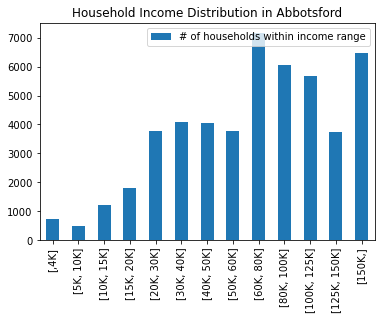

In [28]:
plot_household_income()

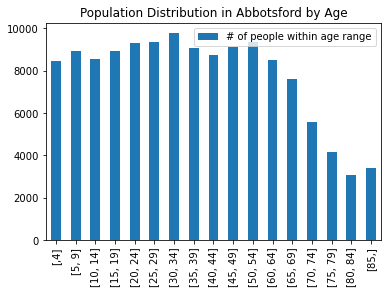

In [29]:
plot_populations_by_age()

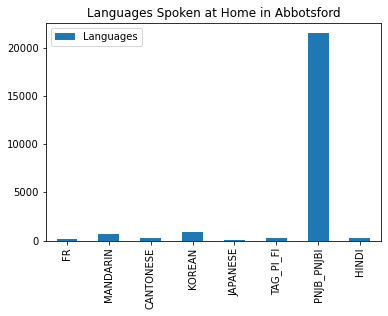

In [30]:
plot_languages_spoken()